# Week 5 : GANs

## Introduction / Description of the Problem



This week's mini project focuses on developing a generative adversarial network or GAN to create images imitating the painter Monet's stlye. The following code will create two neural networks: a generator and a discriminator models. The generator will be creating the images and the discriminator will be the one that trains the generator. The data downloaded from Kaggle's website in https://www.kaggle.com/competitions/gan-getting-started is comprised of 4 folders containing pictures and TFRecords.

As this is my first time working with GANs and I'm relatively new in the world of programming, I used several codes as guidance (refer to last section of the project for references).

First, I start by importing the required libraries and setting up the Tensor Processing Unit (TPU) in order to be able to speed up the learning of our model.


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import random
import pandas as pd
import cv2
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.2.0


# Exploratory Data Analysis (EDA)

## Loading the Data

For this step, I start by loading the data into two separate datasets : Pictures and Monet paintings. The following cell will take the TFRecords from each of the folders and store them in separate variables so we can use them afterwards. The dataset contains 5 TFRecords in the Monet and 20 in the pictures. TFRecords help to store data sequentially instead of scattering all over the disks. After this first step, I'll proceed to evaluate the folders containing images and understand their properties.

In addition, I'm also getting the total quantity of pictures of each folder. We have a total of 300 Monet paintings and 7,038 photos


In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [8]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

MONET_FILENAMES_2 = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
print('Monet Pictures:', len(MONET_FILENAMES_2))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

PHOTO_FILENAMES_2 = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg'))
print('Photo Pictures:', len(PHOTO_FILENAMES_2))

Monet TFRecord Files: 5
Monet Pictures: 300
Photo TFRecord Files: 20
Photo Pictures: 7038


The following lines help us to understand the images properties. All of these files are already sized 256x256. In the code I'm setting the number of channels to 3 as the pictures are RGB images. Then, I perform a scaling to the pictures of [-1, 1] scale.

In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


With the following cell, I'll extract the images (pictures and paintings) from the files and in the will print an example of each. If we compare them, we can easily identify which is a painting and which one is a picture as the paintings moves from color to color suddenly. On the other hand, the pictures expose more natural colors. This observation is going to be useful to evaluate the ouput of my model. 

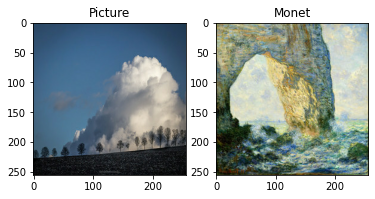

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Picture')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)



The following function helps to get an idea of the color constitution of each image as it plots the RGB distribution of a selected image. I ran 3 random pictures just to understand the data better.

In [16]:
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    
    
    plt.show()

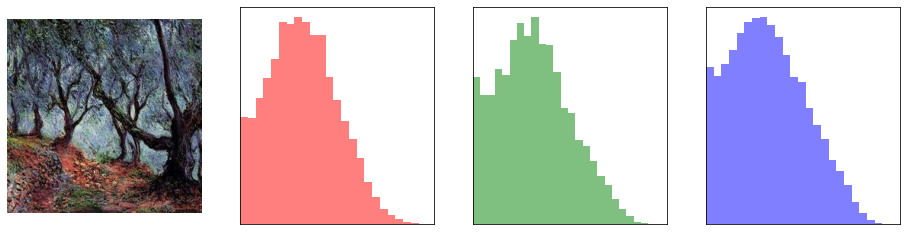

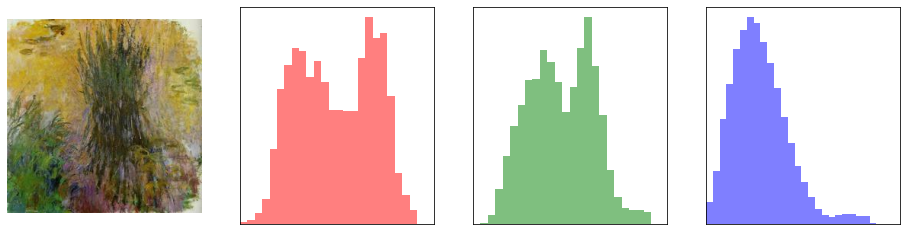

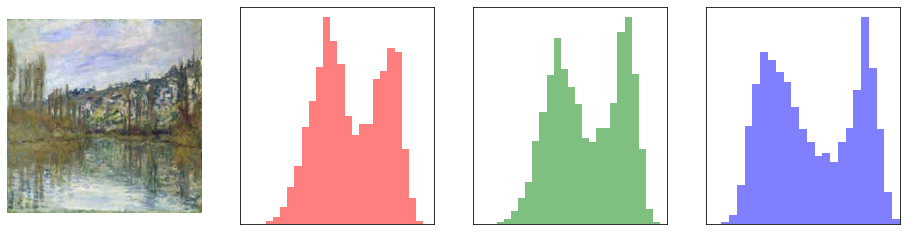

In [20]:
img_path = '../input/monet-gan-getting-started/monet_jpg/011835cfbf.jpg'
color_hist_visualization(img_path)

img_path = '../input/monet-gan-getting-started/monet_jpg/11be65b3e9.jpg'
color_hist_visualization(img_path)

img_path = '../input/monet-gan-getting-started/monet_jpg/184d6c66cd.jpg'
color_hist_visualization(img_path)

# Model building and Training

The tutorial I followed for this project uses a UNET architecture and the reason behind it is because it is a convolutional neural network that processes and classifies images by analyzing every pixel, resulting in an output of the same size as the input. As mentioned in the introduction, I'll create a generator to create the images and a discriminator that will train the model.

In order to create the generator, it is needed first to define a couple of methos called "upsample" and "downsample". Downsample refers to the reduction of height and width of each image by something called "stride". The stride will be the length of each step that the filter uses. In contrast, upsample does the oposite as it increases the image's dimension.

I used as reference Google's website for Machine Learning to understand a little bit better the theory and structure behind these concepts.  The codes created in this project follow the structure depicted in the following pictures:





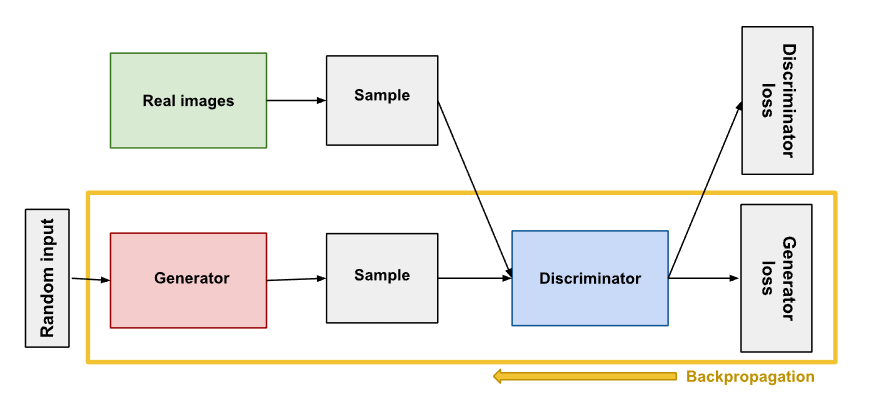

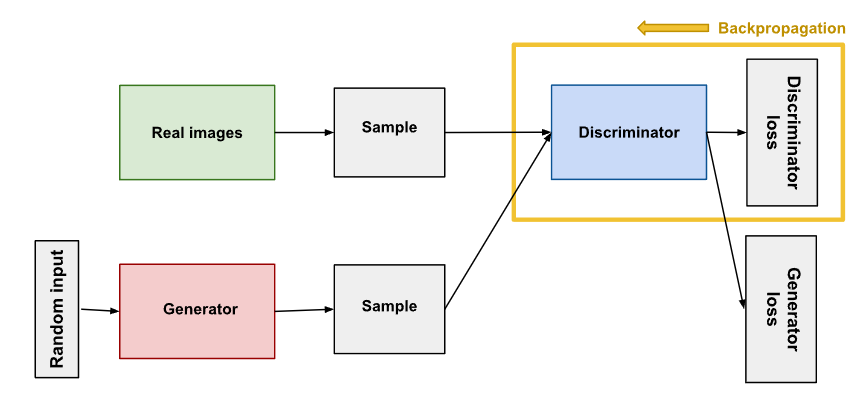

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Once the functions for performing downsamples and upsamples are defined,I'll work on the creationg of the model's generator. The way it works is that it will begin by applying the downsample to the input image and then upsample it. While doing it, it will be concatenating the output of a layer to multiple layers symmetrically instead of only one by bypassing the gradient with the use of skip connections.


In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

After defining the generator function, I'll work on the discriminator. This function will take the image as input and classify it as a fake one or real one. If it is a real one, the output will be a smaller 2D image with higher pixel values. If it is a fake one, it will have lower pixel values.

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Now that the models are created, the next step is to work on the CycleGAN model.

# CycleGAN Model Creation 

The following code takes as basis a`tf.keras.Model` and uses the generator and discriminator functions defined in the previous cells. As the next step is the training of the model, I'll define the training function inside the CycleGan class. The objective will be to have the original picture and the created one as similar as possible. 

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Loss Functions Definition

Now that the main class has been defined, we need to focus on the model's loss functions. First, the discriminator loss function will compare fake pictures to a matrix containing zeroes and real pictures to a matrix containing number ones. A perfect score would be that for real pictures the output would be 1 and for fake 0s. This ouput in the end will be the average of generated and real loss.  

For the generator function, it will compare the generated image to a matrix containing 1s to calculate the loss. As the objective of the model is to get both , picture and painting as similar as possible, we will calculate cycle consistency by just computing their difference.

Lastly, the identity loss function will  compare the image with its image generator or in other words, compare the input and the output of the generator. 

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# CycleGAN Training Step

For the training step, I'll use the .fit() and loss functions to understand the model's performance through each epoch. I decided to run 15 epochs due to computational resources but this is one of the parameters that we can modify in order to get better results. Similarly to the previous projects of the course, I decided to use the Adam function to optimize the model. 

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=15
)

Epoch 1/15
300/300 [==============================] - 140s 124ms/step - monet_gen_loss: 5.0902 - photo_gen_loss: 5.3352 - monet_disc_loss: 0.6722 - photo_disc_loss: 0.6216
Epoch 2/15
  1/300 [..............................] - ETA: 50s - monet_gen_loss: 3.0266 - photo_gen_loss: 2.9246 - monet_disc_loss: 0.6511 - photo_disc_loss: 0.5657

2022-11-21 12:57:08.154745: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 13241, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669035428.151486483","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 13241, Output num: 0","grpc_status":3}


300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.5914 - photo_gen_loss: 3.7362 - monet_disc_loss: 0.6667 - photo_disc_loss: 0.6307
Epoch 3/15
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.5040 - photo_gen_loss: 3.6596 - monet_disc_loss: 0.6578 - photo_disc_loss: 0.6100
Epoch 4/15
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.3791 - photo_gen_loss: 3.5478 - monet_disc_loss: 0.6470 - photo_disc_loss: 0.6096
Epoch 5/15
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.2595 - photo_gen_loss: 3.4090 - monet_disc_loss: 0.6344 - photo_disc_loss: 0.6035
Epoch 6/15
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.1721 - photo_gen_loss: 3.2793 - monet_disc_loss: 0.6273 - photo_disc_loss: 0.6123
Epoch 7/15
300/300 [==============================] - 37s 124ms/step - monet_gen_loss: 3.1380 - photo_gen_loss: 3.2225 - monet_disc_loss: 0.6186 - photo_dis

# Results Analysis

After training is completed, the model ended with similar loss values between Monet and Picture functions which I believe that if this was not for educational purposes, we would need to improve them by playing around with its parameters. However, as this model is part of a mini project its performance is acceptable. I put it to test with the following cell by getting 8 samples. 

I'm not a person that is "art-trained" nor have the experience to do a good paint analysis so I'm really impressed by the results shown below. For me, they really have this "Monet-esque" appearance. 

The last step is just to prepare the results for the competition's submission into Kaggle's website. Once I did it, it gave me a scoe of 63.64

2022-11-21 13:05:56.539465: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 58138, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669035956.539362910","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 58138, Output num: 0","grpc_status":3}


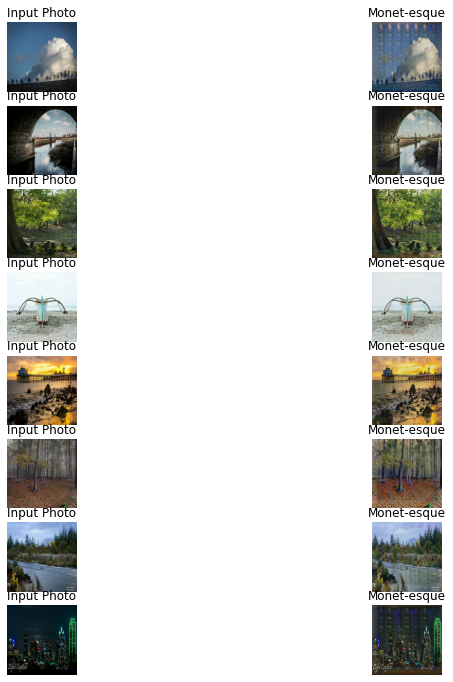

In [23]:
_, ax = plt.subplots(8, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(8)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [25]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-11-21 13:38:47.727503: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 4632847, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1669037927.727344620","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4632847, Output num: 0","grpc_status":3}


In [26]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusions

As stated in the previous sections, I believe the results gotten by the model are acceptable as I'm a Data Science student who is just beginning in the programming world and also considering that I'm not an art expert. However, the model's performance could be improved if we were to use a bigger training dataset and use other different methods for loss functions.  Thanks to this project, I can have a better idea of how picture filters in social networks like Instagram work and have in mind other applications of GANs.

Personally, my next step is to use this model in other type of datasets to fully understand its capabilities and then being more capable of improving it. 

# References
* Monet CycleGAN Tutorial , Jang, Amy. Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
* UNET - Line by Line Explanation , Zhang, Jeremy. Towards Data Science. https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
* Monet CycleGAN MLIP 2021 , Anna . Kaggle. https://www.kaggle.com/code/annatmp/monet-cyclegan-mlip-2021
* Monet - Visualization and Augmentation , Isaienkov, Yaroslav. Kaggle . https://www.kaggle.com/code/ihelon/monet-visualization-and-augmentation/notebook
* The Generator. Machine Learning. https://developers.google.com/machine-learning/gan/generator
* The Discriminator . Machine Learning. https://developers.google.com/machine-learning/gan/discriminator


